# Chapter 15

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [27]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

#### 15.1

In [3]:
pancake = np.array([[1,1],[1,0],[0,0]])
# simulate a pancake and return randomly ordered sides
pancakes = np.asarray([np.random.permutation(pancake[np.random.choice(range(3))]) for i in range(10000)])
up = pancakes[:, 0]
down = pancakes[:, 1]

# compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up==1)
num_11 = np.sum((up==1) & (down==1))
num_11/num_11_10

0.6630065881413456

#### 15.2

In [5]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


Text(0, 0.5, 'Divorce rate')

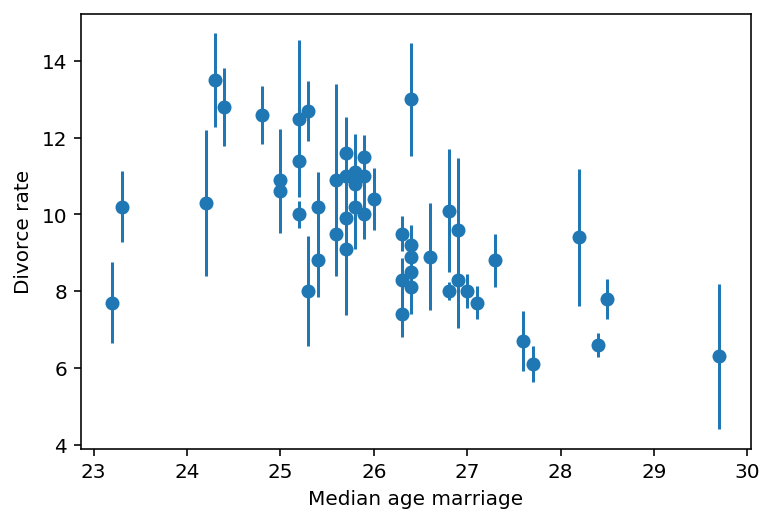

In [26]:
d = pd.read_csv('Data/WaffleDivorce.csv', ';')

fig, ax = plt.subplots()
ax.scatter(d["MedianAgeMarriage"].values, d["Divorce"].values)
ax.errorbar(d["MedianAgeMarriage"].values ,d["Divorce"].values, yerr=d["Divorce SE"].values, ls='none')

ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate")

#### 15.3

In [36]:
# Standardize regressors and target
D_obs = standardize(d["Divorce"])
D_sd = d["Divorce SE"] / d["Divorce"].std()
M = standardize(d["Marriage"])
A = standardize(d["MedianAgeMarriage"])
N = len(d)

with pm.Model() as m_15_1:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, .5)
    bA = pm.Normal("bA", 0, .5)
    a = pm.Normal("a", 0, .2)
    mu = pm.Deterministic("mu", a + bA*A + bM*M)
    
    D_true = pm.Normal("D_true", mu, sigma, shape=N)
    D_obs = pm.Normal("D_obs", D_true, D_sd, observed=D_obs)
    
    trace_m_15_1 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_true, a, bA, bM, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2107.21draws/s]


#### 15.4

In [37]:
az.summary(trace_m_15_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,0.051,0.167,-0.262,0.360,0.004,0.003,1401.0,1184.0,1397.0,1494.0,1.0
bA,-0.614,0.159,-0.893,-0.305,0.004,0.003,1326.0,1285.0,1322.0,1299.0,1.0
a,-0.055,0.095,-0.237,0.117,0.002,0.002,2017.0,1646.0,2025.0,1746.0,1.0
D_true[0],1.163,0.361,0.438,1.758,0.008,0.006,2239.0,2032.0,2248.0,1683.0,1.0
D_true[1],0.684,0.550,-0.340,1.769,0.011,0.009,2743.0,1760.0,2716.0,1696.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu[45],-0.221,0.113,-0.441,-0.030,0.003,0.002,1598.0,1559.0,1590.0,1711.0,1.0
mu[46],0.038,0.109,-0.170,0.237,0.003,0.002,1867.0,1392.0,1868.0,1582.0,1.0
mu[47],0.493,0.140,0.242,0.767,0.003,0.002,1933.0,1912.0,1931.0,1533.0,1.0
mu[48],-0.216,0.138,-0.470,0.040,0.003,0.002,1831.0,1686.0,1834.0,1644.0,1.0


#### 15.5

In [41]:
# Standardize regressors and target
D_obs = standardize(d["Divorce"])
D_sd = d["Divorce SE"] / d["Divorce"].std()
M_obs = standardize(d["Marriage"])
M_sd = d["Marriage SE"] / d["Marriage"].std()

A = standardize(d["MedianAgeMarriage"])
N = len(d)

with pm.Model() as m_15_2:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, .5)
    bA = pm.Normal("bA", 0, .5)
    a = pm.Normal("a", 0, .2)
        
    M_true = pm.Normal("M_true", 0, 1, shape=N)

    mu = pm.Deterministic("mu", a + bA*A + bM*M_true)
    
    D_true = pm.Normal("D_true", mu, sigma, shape=N)
    D_obs = pm.Normal("D_obs", D_true, D_sd, observed=D_obs)
    M_obs = pm.Normal("M_obs", M_true, M_sd, observed=M_obs)

    
    trace_m_15_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [D_true, M_true, a, bA, bM, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1828.75draws/s]


In [42]:
az.summary(trace_m_15_2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,0.199,0.207,-0.203,0.564,0.006,0.005,1132.0,954.0,1141.0,1113.0,1.0
bA,-0.544,0.161,-0.844,-0.223,0.004,0.003,1636.0,1632.0,1626.0,1233.0,1.0
a,-0.043,0.095,-0.219,0.140,0.002,0.002,2520.0,1523.0,2521.0,1864.0,1.0
M_true[0],0.073,0.327,-0.514,0.708,0.006,0.008,3393.0,867.0,3390.0,1590.0,1.0
M_true[1],1.025,0.610,-0.107,2.155,0.009,0.008,4189.0,2719.0,4196.0,1613.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu[45],-0.177,0.134,-0.431,0.067,0.003,0.002,1891.0,1846.0,1911.0,1734.0,1.0
mu[46],0.086,0.135,-0.158,0.342,0.003,0.002,1966.0,1539.0,2015.0,1446.0,1.0
mu[47],0.513,0.174,0.203,0.854,0.003,0.003,2468.0,2199.0,2512.0,2054.0,1.0
mu[48],-0.298,0.155,-0.593,-0.007,0.004,0.003,1318.0,1318.0,1310.0,1320.0,1.0


#### 15.6

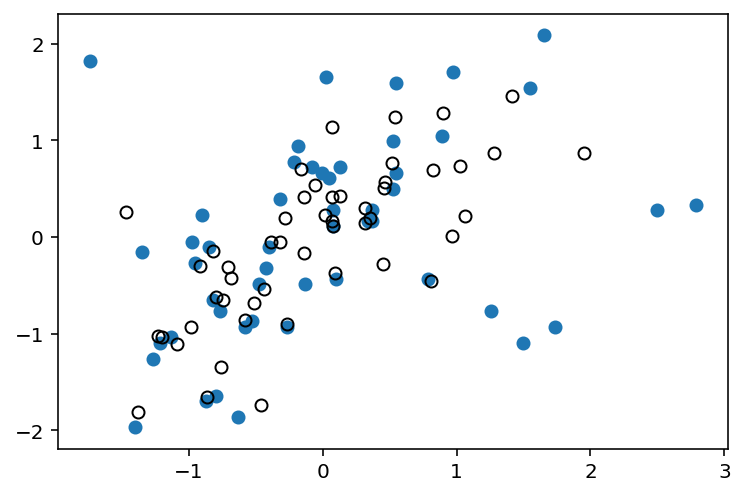

In [51]:
# Copying these two lines as they got overwritten by model
M_obs = standardize(d["Marriage"])
D_obs = standardize(d["Divorce"])


D_true = trace_m_15_2["D_true"].mean(axis=0)
M_true = trace_m_15_2["M_true"].mean(axis=0)

fig, ax = plt.subplots()
ax.scatter(M_obs, D_obs)
ax.scatter(M_true, D_true, edgecolor="k", color=(0, 0, 0, 0))

